In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [102]:
import sys

sys.path.append("..")

from config.config import Config

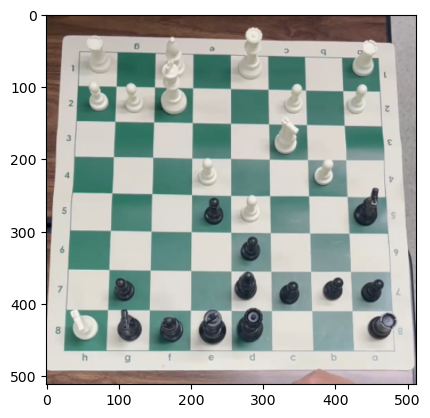

In [103]:
img = cv2.imread(Config.IMAGE_DIR / "test" / "chess4.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, Config.IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

plt.imshow(img)

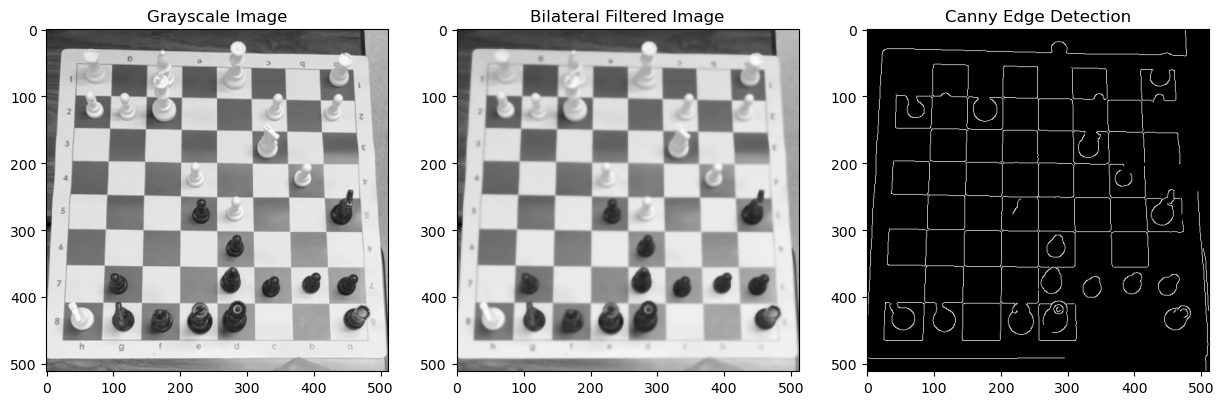

In [104]:
def cannyPF(img, sigma=0.25):
    med = np.median(img)
    lower = int(max(0, (1.0 - sigma) * med))
    upper = int(min(255, (1.0 + sigma) * med))
    return cv2.Canny(img, lower, upper)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

bilateral = cv2.bilateralFilter(gray, d=7, sigmaColor=75, sigmaSpace=75)

canny = cannyPF(bilateral, sigma=0.33)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(gray, cmap='gray')
ax[0].set_title('Grayscale Image')
ax[1].imshow(bilateral, cmap='gray')
ax[1].set_title('Bilateral Filtered Image')
ax[2].imshow(canny, cmap='gray')
ax[2].set_title('Canny Edge Detection')
plt.show()

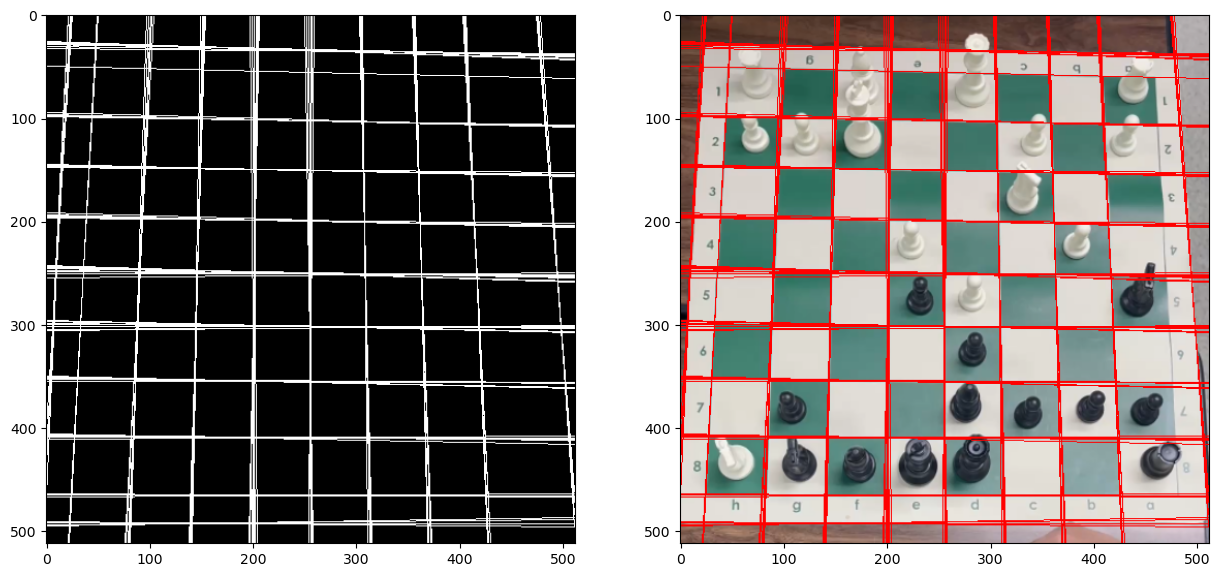

In [105]:
lines = cv2.HoughLines(canny, 1, np.pi/720.0, 50, np.array([]), 0, 0)
lines_best = np.squeeze(lines)[:100]

black = np.zeros_like(img)
canvas = img.copy()

points = []

for rho, theta in lines_best:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(black, (x1, y1), (x2, y2), (255, 255, 255), 1)
    cv2.line(canvas, (x1, y1), (x2, y2), (255, 0, 0), 1)
    points.append(((x1, y1), (x2, y2)))

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(black)
ax[1].imshow(canvas)
plt.show()

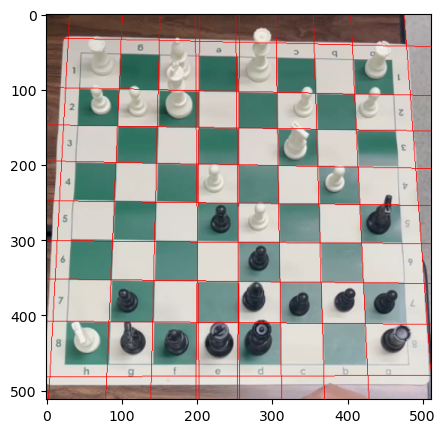

In [106]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalize features (rho and theta have different scales)
scaler = StandardScaler()
lines_normalized = scaler.fit_transform(lines_best)

# Cluster similar lines
clustering = DBSCAN(eps=0.1, min_samples=2).fit(lines_normalized)
labels = clustering.labels_

# Average lines within each cluster
unique_lines = []
for label in set(labels):
    if label != -1:  # Not noise
        cluster_lines = lines_best[labels == label]
        avg_rho = np.mean(cluster_lines[:, 0])
        avg_theta = np.mean(cluster_lines[:, 1])
        unique_lines.append([avg_rho, avg_theta])

# Draw averaged lines
canvas = img.copy()
for rho, theta in unique_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(canvas, (x1, y1), (x2, y2), (255, 0, 0), 1)

plt.figure(figsize=(5, 5))
plt.imshow(canvas)
plt.show()

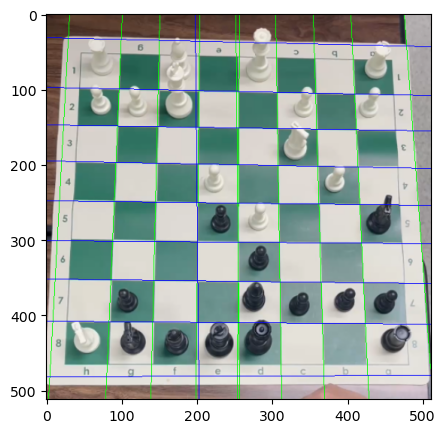

In [107]:
group1, group2 = [], []
group1_mean, group2_mean = None, None

for i, (rho, theta) in enumerate(unique_lines):
  if group1_mean is None:
    # First line → group 1
    group1.append(i)
    group1_mean = theta
  elif group2_mean is None:
    # Check if perpendicular to group1
    diff = abs(theta - group1_mean)
    if diff > np.pi/3:  # ~60 degrees
      group2.append(i)
      group2_mean = theta
    else:
      group1.append(i)
      # Update running mean
      group1_mean = np.mean([unique_lines[j][1] for j in group1])
  else:
    # Assign to closest group
    diff1 = min(abs(theta - group1_mean), 
                np.pi - abs(theta - group1_mean))
    diff2 = min(abs(theta - group2_mean),
                np.pi - abs(theta - group2_mean))
    
    if diff1 < diff2:
      group1.append(i)
      group1_mean = np.mean([unique_lines[j][1] for j in group1])
    else:
      group2.append(i)
      group2_mean = np.mean([unique_lines[j][1] for j in group2])

canvas = img.copy()
for i in group1:
  rho, theta = unique_lines[i]
  a = np.cos(theta)
  b = np.sin(theta)
  x0 = a * rho
  y0 = b * rho
  x1 = int(x0 + 1000 * (-b))
  y1 = int(y0 + 1000 * (a))
  x2 = int(x0 - 1000 * (-b))
  y2 = int(y0 - 1000 * (a))
  cv2.line(canvas, (x1, y1), (x2, y2), (0, 255, 0), 1)
for i in group2:
  rho, theta = unique_lines[i]
  a = np.cos(theta)
  b = np.sin(theta)
  x0 = a * rho
  y0 = b * rho
  x1 = int(x0 + 1000 * (-b))
  y1 = int(y0 + 1000 * (a))
  x2 = int(x0 - 1000 * (-b))
  y2 = int(y0 - 1000 * (a))
  cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 1)

plt.figure(figsize=(5, 5))
plt.imshow(canvas)
plt.show()

Selecting best 9 lines from Group 1...
Selecting best 9 lines from Group 2...

Group 1: Selected 9 lines
Group 2: Selected 9 lines


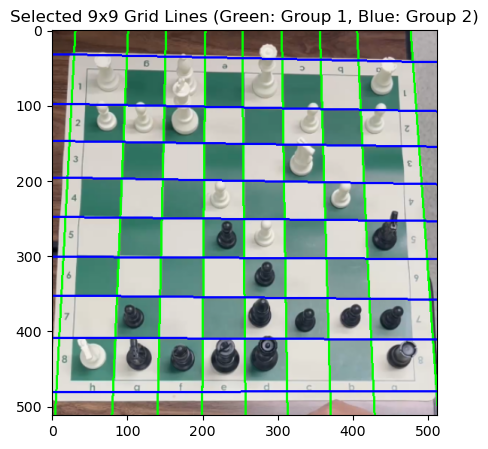


Group 1 spacing:
  Mean spacing: 84.91 pixels
  Std deviation: 75.45 pixels
  Spacings: ['70.2', '48.8', '51.0', '52.5', '283.3', '71.0', '50.5', '52.0']

Group 2 spacing:
  Mean spacing: 56.20 pixels
  Std deviation: 8.10 pixels
  Spacings: ['66.1', '49.2', '48.3', '52.7', '52.9', '51.8', '55.8', '72.7']


In [108]:
import itertools

def select_best_9_lines(group_indices, unique_lines):
    """Select 9 lines with most uniform spacing"""
    
    # Extract lines and sort by rho (handle negative rho)
    lines_with_idx = [(i, unique_lines[i][0], unique_lines[i][1]) for i in group_indices]
    
    # Normalize: if rho < 0, flip to positive and adjust theta
    normalized = []
    for idx, rho, theta in lines_with_idx:
        if rho < 0:
            rho = -rho
            theta = theta + np.pi if theta < np.pi else theta - np.pi
        normalized.append((idx, rho, theta))
    
    # Sort by rho
    normalized.sort(key=lambda x: x[1])
    sorted_indices = [x[0] for x in normalized]
    sorted_rhos = [x[1] for x in normalized]
    
    if len(sorted_indices) <= 9:
        return sorted_indices
    
    # Try all combinations
    best_indices = None
    best_score = float('inf')
    
    for combo in itertools.combinations(range(len(sorted_indices)), 9):
        combo_rhos = [sorted_rhos[i] for i in combo]
        
        # Linear fit
        x = np.arange(9)
        poly_coeffs = np.polyfit(x, combo_rhos, deg=2)
        predicted = np.polyval(poly_coeffs, x)
        mse = np.mean((combo_rhos - predicted) ** 2)
        
        if mse < best_score:
            best_score = mse
            best_indices = [sorted_indices[i] for i in combo]
    
    return best_indices

# Select best 9 lines from each group
print("Selecting best 9 lines from Group 1...")
best_group1 = select_best_9_lines(group1, unique_lines)
print("Selecting best 9 lines from Group 2...")
best_group2 = select_best_9_lines(group2, unique_lines)

print(f"\nGroup 1: Selected {len(best_group1)} lines")
print(f"Group 2: Selected {len(best_group2)} lines")

# Visualize the selected lines
canvas = img.copy()
for i in best_group1:
    rho, theta = unique_lines[i]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(canvas, (x1, y1), (x2, y2), (0, 255, 0), 2)

for i in best_group2:
    rho, theta = unique_lines[i]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.figure(figsize=(5, 5))
plt.imshow(canvas)
plt.title('Selected 9x9 Grid Lines (Green: Group 1, Blue: Group 2)')
plt.show()

# Optional: Show spacing uniformity
for group_name, best_indices in [("Group 1", best_group1), ("Group 2", best_group2)]:
    rhos_selected = sorted([unique_lines[i][0] for i in best_indices])
    diffs = np.diff(rhos_selected)
    print(f"\n{group_name} spacing:")
    print(f"  Mean spacing: {np.mean(diffs):.2f} pixels")
    print(f"  Std deviation: {np.std(diffs):.2f} pixels")
    print(f"  Spacings: {[f'{d:.1f}' for d in diffs]}")